In [68]:
import torch
import random
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [69]:
dataset = CIFAR10(
    root='data/',
    download=True,
    transform=ToTensor())
test_dataset = CIFAR10(root='data/', train=False, transform=ToTensor())

Files already downloaded and verified


In [70]:
classes = dataset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Label (numeric): 6
Label (textual): frog


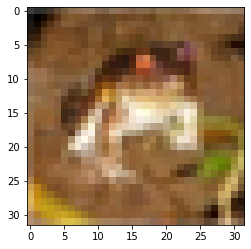

In [71]:
img, label = dataset[0]
plt.imshow(img.permute((1, 2, 0)))
print('Label (numeric):', label)
print('Label (textual):', classes[label])

In [73]:
class_count = {}
for _, index in dataset:
    label = classes[index]
    if label not in class_count:
        class_count[label] = 0
    class_count[label] += 1
print(class_count)

{'frog': 5000, 'truck': 5000, 'deer': 5000, 'automobile': 5000, 'bird': 5000, 'horse': 5000, 'ship': 5000, 'cat': 5000, 'dog': 5000, 'airplane': 5000}


In [102]:
torch.manual_seed(43)
val_size = 10000
train_size = len(dataset) - val_size
#The “seed” is a starting point for the sequence and the guarantee is that
#if you start from the same seed you will get the same sequence of numbers 

In [103]:
train_ds, val_ds = random_split(dataset, [train_size, val_size]) 
len(train_ds), len(val_ds)
#random_split method is used to create the training and validation sets

(40000, 10000)

In [104]:
batch_size=128
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True)
#Dataloader combines a dataset and a sampler, and provides an iterable over the given dataset
#samplers are to determine how batches should be formed

images.shape: torch.Size([128, 3, 32, 32])


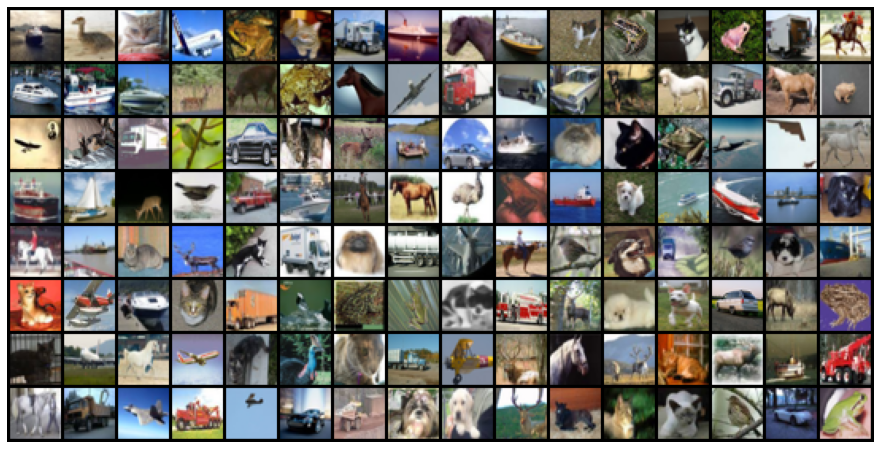

In [105]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [106]:
@torch.no_grad()
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [107]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [108]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [109]:
torch.cuda.is_available()

False

In [110]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [111]:
device = get_default_device()
device

device(type='cpu')

In [112]:
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [113]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

In [114]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [115]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [116]:
input_size = 3*32*32
output_size = 10

In [117]:
class CIFAR10Model( ImageClassificationBase ):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(input_size, 1536)
        self.linear2 = nn.Linear(1536, 768)         # hidden layers
        self.linear3 = nn.Linear(768, 384)          # hidden layers
        self.linear4 = nn.Linear(384, 128)          # hidden layers
        self.linear5 = nn.Linear(128, output_size)  # output layer
        
    def forward(self, xb):
        # Flatten images into vectors
        out = xb.view(xb.size(0), -1)
        # Apply layers & activation functions
        out = self.linear1(out)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)
        out = F.relu(out)
        out = self.linear4(out)
        out = F.relu(out)
        out = self.linear5(out)
        return out
    #ReLU activation function is used as it will output the input directly if it is positive, otherwise, it will output zero.

In [119]:
model = to_device(CIFAR10Model(), device)

In [120]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.305337429046631, 'val_acc': 0.10136719048023224}]

In [121]:
training_params = [
    (10, 1e-2),
    (20, 1e-3),
    (20, 1e-4),
    (20, 1e-5),
    (15, 5e-6)
]
for epochs, lr in training_params:
    print(f"Training for {epochs} epochs, with a learning rate of {lr}...")
    history += fit(epochs, lr, model, train_loader, val_loader)

Training for 10 epochs, with a learning rate of 0.01...
Epoch [0], val_loss: 2.2948, val_acc: 0.1633
Epoch [1], val_loss: 2.2693, val_acc: 0.1521
Epoch [2], val_loss: 2.1765, val_acc: 0.1688
Epoch [3], val_loss: 2.0809, val_acc: 0.1998
Epoch [4], val_loss: 2.0434, val_acc: 0.2324
Epoch [5], val_loss: 2.0136, val_acc: 0.2505
Epoch [6], val_loss: 1.9710, val_acc: 0.2799
Epoch [7], val_loss: 1.9300, val_acc: 0.2978
Epoch [8], val_loss: 1.8951, val_acc: 0.3187
Epoch [9], val_loss: 1.8681, val_acc: 0.3311
Training for 20 epochs, with a learning rate of 0.001...
Epoch [0], val_loss: 1.8644, val_acc: 0.3310
Epoch [1], val_loss: 1.8611, val_acc: 0.3294
Epoch [2], val_loss: 1.8582, val_acc: 0.3307
Epoch [3], val_loss: 1.8560, val_acc: 0.3314
Epoch [4], val_loss: 1.8559, val_acc: 0.3320
Epoch [5], val_loss: 1.8516, val_acc: 0.3325
Epoch [6], val_loss: 1.8500, val_acc: 0.3334
Epoch [7], val_loss: 1.8484, val_acc: 0.3340
Epoch [8], val_loss: 1.8448, val_acc: 0.3375
Epoch [9], val_loss: 1.8424, val

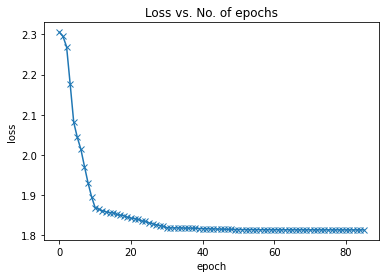

In [122]:
plot_losses(history)

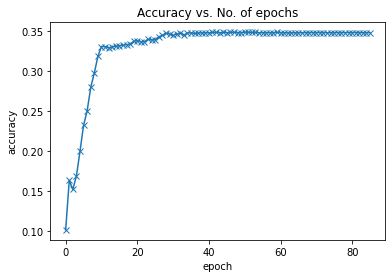

In [123]:
plot_accuracies(history)

In [124]:
evaluate(model, test_loader)

{'val_loss': 1.807324767112732, 'val_acc': 0.34746092557907104}